#### In this notebook we are testing and validating our Quintile distribution hypothesis, using t_stat and p value

Null hypothesis [H0] =  There returns are not impacted by NPT (Net Positive Tone).

Alternate hypothesis [H1] = Returns fluctuate based on Net positive tone


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()

In [2]:
df = pd.read_csv('../returns_tone_master.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
column_names = 'date','price','returns','cik','file_name','filing_date','phi_pos','phi_neg','phi_npt','num_cleaned_words','ticker'

In [5]:
df=df.reindex(columns= column_names)

In [6]:
# max is numbers are extremly high - outlier. so we will remove the outliers. 
# we consider outlier as anything that is 3 times of the standard numbers

In [7]:
date_cols = ['date', 'filing_date']
for date in date_cols:
    df[date] = pd.to_datetime(df[date], format='%Y-%m-%d')
    
df = df[abs(df['returns']) <=  (df['returns'].std() *3)]

In [8]:
# now we separate the data into quintile based on net positive tone, by creating a new column

In [9]:
q_labels = ['quintile' + str(i) for i in range(1,6)]

df['quintile_npt_rank'] = df.groupby('date')['phi_npt'].transform(lambda x: pd.qcut(x=x, q=5, labels = q_labels ))

In [10]:
# now we will average the returns based on quintiles.
# by grouping returns based on quintile and date

In [11]:
sentiment_return = df.groupby(['date','quintile_npt_rank'])['returns'].mean().unstack()
sentiment_return.dropna(inplace=True)

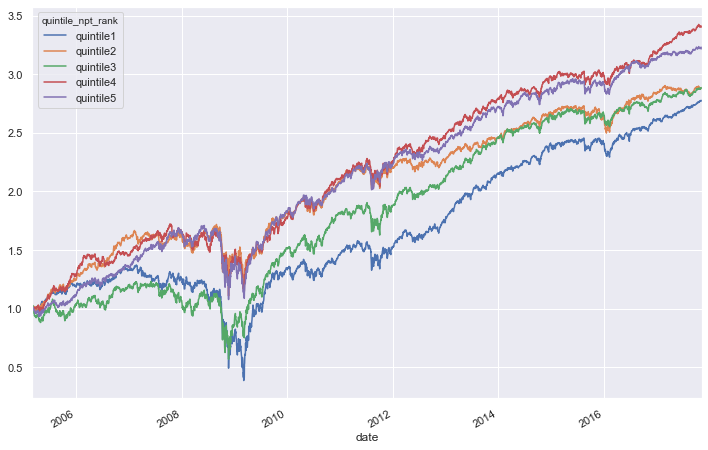

In [12]:
(1 + sentiment_return.cumsum()).plot(figsize=(12 ,8))

In [ ]:
# t stat

In [36]:
mean_diff = (sentiment_return['quintile5'] - sentiment_return['quintile1']).mean()
std_dev = (sentiment_return['quintile5'] - sentiment_return['quintile1']).std()

In [16]:
tstat = mean_diff / (std_dev / np.sqrt(len(sentiment_return)))

In [17]:
tstat

1.0516585054996193

In [ ]:
# t stat value is less than 2, this means the null hypothesis holds. no evidence to support our alternative
# so we cannot conclude that the returns of firms with positive tone are higher than those with lower npt 

In [ ]:
# we are trying to dig a little deeper into year wise data and check if our annual data also gives us the same results?
# we are doing this because in our graph we see a different pattern around year 2006-08

In [18]:
sentiment_return.head()

quintile_npt_rank,quintile1,quintile2,quintile3,quintile4,quintile5
date,,,,,
2005-02-28,-0.006721,0.002292,-0.009611,-0.006633,-0.009890
2005-03-01,0.007352,0.004593,0.024596,0.001139,0.012133
2005-03-02,-0.003139,-0.007467,0.000705,0.005407,0.001424
2005-03-03,-0.002653,0.000331,0.004094,-0.005462,-0.004653
2005-03-04,0.008558,0.020013,0.007742,0.008317,0.008014


In [32]:
years = sentiment_return.index.year.unique()

In [33]:
years

Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017],
           dtype='int64', name='date')

In [25]:
# so to pull numbers year wise, we have to convert them to string 
# and pull annual t stat values

In [34]:
years = [str(year) for year in years]

In [45]:
yearly_result = {}
for year in years:
    df_yr = sentiment_return[year]
    results = stats.ttest_rel(df_yr['quintile5'], df_yr['quintile1'])
    yearly_result[year] = results
    

In [46]:
pd.DataFrame(yearly_result,index=['t_stat','p_val'])

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
t_stat,-0.710327,1.109006,3.232096,0.978339,-0.554602,1.471383,0.804059,-0.687611,-1.066599,-1.166570,0.310616,0.239342,-1.143835
p_val,0.478278,0.268493,0.001394,0.328845,0.579661,0.142440,0.422124,0.492338,0.287178,0.244491,0.756350,0.811036,0.253952


In [47]:
# now lets compare annual t-stat and pvalues

In [88]:
recession_sample = sentiment_return['2005':'2008']

In [68]:
# 2005 : 2008
stats.ttest_rel(recession_sample['quintile5'],recession_sample['quintile1'])

Ttest_relResult(statistic=2.157867834772321, pvalue=0.031183499153527947)

In [70]:
# 2006:2009
stats.ttest_rel(recession_sample['quintile5'],recession_sample['quintile1'])

Ttest_relResult(statistic=1.630548863517708, pvalue=0.10329856380479231)

In [72]:
# 2006: 2008
stats.ttest_rel(recession_sample['quintile5'],recession_sample['quintile1'])

Ttest_relResult(statistic=2.6051194610203328, pvalue=0.009365257033268947)

In [74]:
# 2007:2008
stats.ttest_rel(recession_sample['quintile5'],recession_sample['quintile1'])

Ttest_relResult(statistic=2.3655861499733732, pvalue=0.0183798828404258)

In [78]:
# 2007
stats.ttest_rel(recession_sample['quintile5'],recession_sample['quintile1'])

Ttest_relResult(statistic=3.2320955825938187, pvalue=0.0013940096789092171)

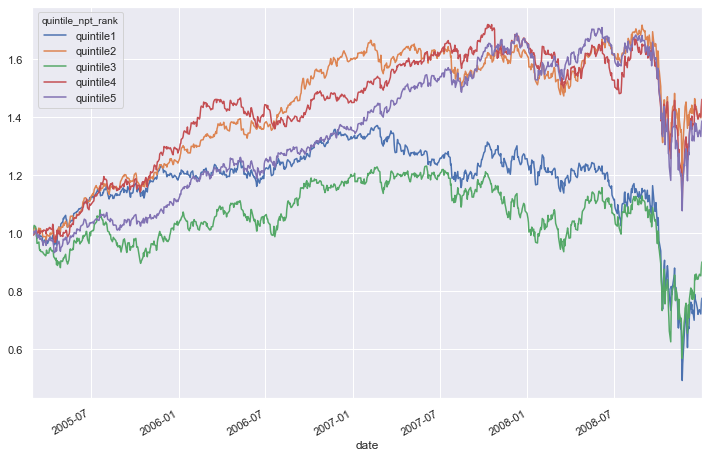

In [89]:
(1 + recession_sample.cumsum()).plot(figsize=(12 ,8))

Findings:

1) Our Quintile distribution does not change based on NPT, thus Null hypothesis holds.

2) However we also notice that our Quintiles are drastically affected by NPT during the years 2005 through 2007/2008. This is during the market crisis scenario.

Hence it is safe to say that even if overall our model may not prove to be right about NPT impacting returns, in times of crisis however, our alternate hypothesis holds rejecting the null.